In [1]:
%matplotlib inline

import numpy as np  # linear algebra
import os
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import ct_utils

# Some constants
INPUT_FOLDER = '/home/gaetano/Desktop/DATA/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

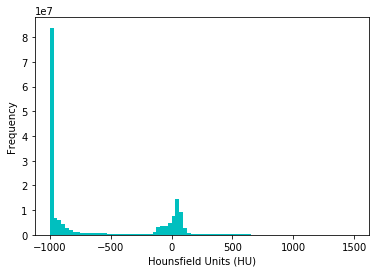

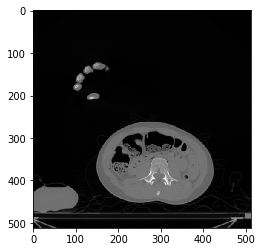

In [2]:

first_patient = ct_utils.load_scan(INPUT_FOLDER + patients[1])
first_patient_pixels = ct_utils.get_pixels_hu(first_patient)

# Show histogram of Hounsfield density bins
plt.hist(first_patient_pixels.flatten(), bins=80, range=(-1000, 1500) ,color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [3]:
# Resample volume

pix_resampled, spacing = ct_utils.resample(first_patient_pixels, first_patient, [1, 1, 1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (1285, 512, 512)
Shape after resampling	 (642, 445, 445)


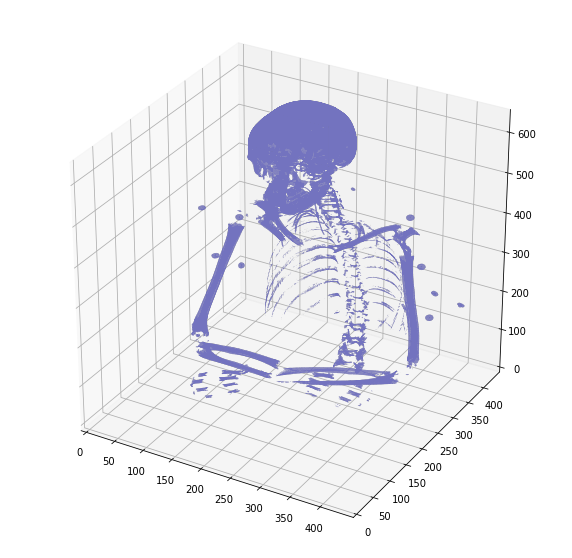

In [4]:
ct_utils.plot_3d(pix_resampled, 1000)

In [5]:
# vv = visualize_volumes.ImageSliceViewer3D(pix_resampled)
ct_utils.make_gifs(pix_resampled, "test_gif", "axial")

		done with axial gif


![SegmentLocal](test_gif_axial.gif "segment")

In [ ]:
def jaw_segmenter(volume, hu_threshold=(1600, 2000), iterations=2, cut_off=1.5, growth_rate=1):
    hu_min = hu_threshold[0]
    hu_max = hu_threshold[1]
    filtered_image = ct_utils.filter_bounds(volume, hu_min, hu_max)
    binary_image = ct_utils.binarize(filtered_image)
    non_zero_coords = np.array(list(zip(*map(list, binary_image.nonzero()))))
    distance_mat = distance_matrix([non_zero_coords.mean(axis=0)], non_zero_coords)

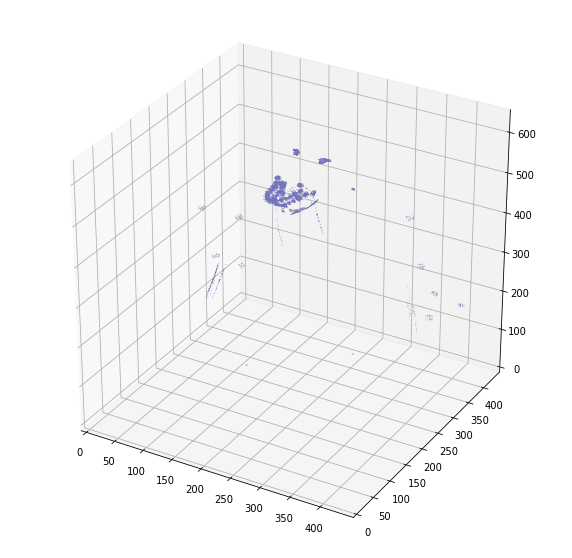

In [18]:
filtered_image = ct_utils.filter_bounds(pix_resampled, 1600, 2000)
ct_utils.plot_3d(filtered_image)

In [19]:
filtered_image.shape

binary_image = ct_utils.binarize(filtered_image)
non_zero_coords = np.array(list(zip(*map(list, binary_image.nonzero()))))

np.mean(non_zero_coords, axis=0)
np.std(non_zero_coords, axis=0)

array([71.00797647, 27.94882761, 57.76102408])

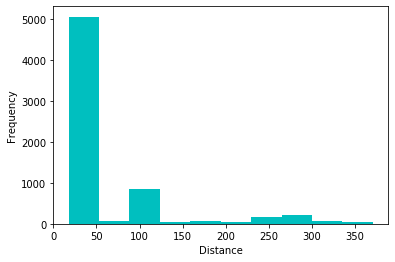

65.74373793017692


In [20]:
distance_mat = distance_matrix([non_zero_coords.mean(axis=0)], non_zero_coords)

plt.hist(distance_mat[0] ,color='c')
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()
print(np.mean(distance_mat))

In [21]:
std_dev = np.mean(distance_mat)
args_to_keep = np.argwhere(distance_mat[0]<std_dev * 1.5)
bounding_coords = non_zero_coords[args_to_keep]
max_box = np.amax(bounding_coords, axis=0)[0]
min_box = np.amin(bounding_coords, axis=0)[0]
jaw_isolated = pix_resampled[min_box[0]:max_box[0], min_box[1]:max_box[1], min_box[2]:max_box[2]]

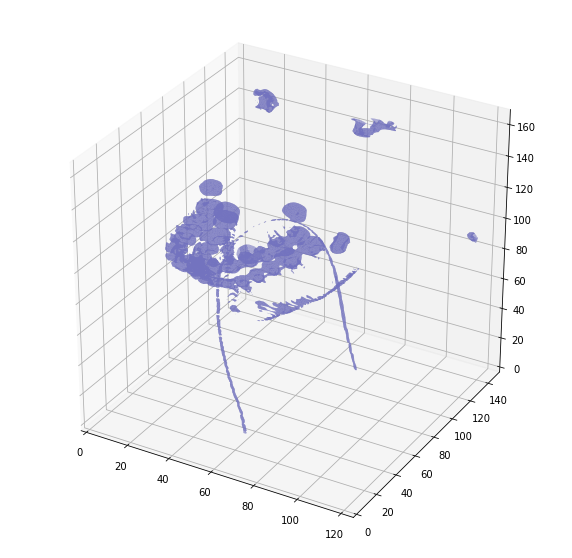

In [23]:
# %matplotlib widget
ct_utils.plot_3d(jaw_isolated, 1600)

In [11]:
# Normalize the image between selected HU units

MIN_BOUND = 1600.0
MAX_BOUND = 1800.0

def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

In [12]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image